https://github.com/karpathy/makemore

https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part2_mlp.ipynb

https://colab.research.google.com/drive/1YIfmkftLrz6MPTOO9Vwqrop2Q5llHIGK?usp=sharing

Bengio et al. 2003 MLP language model paper (pdf):
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

PyTorch internals:
https://blog.ezyang.com/2019/05/pytorch-internals/

## Exercises:

- E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2

- E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?
    
- E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read all the words
read_file = open('names.txt', 'r')
words = read_file.read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of chars and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 # special char for Start and End of the word
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build a dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], [] # X = input, Y = label

for w in words:
  print(w)
  context = [0] * block_size
  for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

Streaming output truncated to the last 5000 lines.
michail
... ---> m
..m ---> i
.mi ---> c
mic ---> h
ich ---> a
cha ---> i
hai ---> l
ail ---> .
michale
... ---> m
..m ---> i
.mi ---> c
mic ---> h
ich ---> a
cha ---> l
hal ---> e
ale ---> .
mihail
... ---> m
..m ---> i
.mi ---> h
mih ---> a
iha ---> i
hai ---> l
ail ---> .
miken
... ---> m
..m ---> i
.mi ---> k
mik ---> e
ike ---> n
ken ---> .
mikyng
... ---> m
..m ---> i
.mi ---> k
mik ---> y
iky ---> n
kyn ---> g
yng ---> .
mila
... ---> m
..m ---> i
.mi ---> l
mil ---> a
ila ---> .
moaaz
... ---> m
..m ---> o
.mo ---> a
moa ---> a
oaa ---> z
aaz ---> .
moaz
... ---> m
..m ---> o
.mo ---> a
moa ---> z
oaz ---> .
moeez
... ---> m
..m ---> o
.mo ---> e
moe ---> e
oee ---> z
eez ---> .
mohamadou
... ---> m
..m ---> o
.mo ---> h
moh ---> a
oha ---> m
ham ---> a
ama ---> d
mad ---> o
ado ---> u
dou ---> .
mohammadomar
... ---> m
..m ---> o
.mo ---> h
moh ---> a
oha ---> m
ham ---> m
amm ---> a
mma ---> d
mad ---> o
ado ---> m
dom ---> a

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [8]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [9]:
# random init of C
C = torch.randn((27, 2))

In [10]:
C[5]
# or you can use one_hot and get the same result - see cell below
# currently we will use indexing, because is simpler and faster!

tensor([ 0.1294, -0.6109])

In [11]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 0.1294, -0.6109])

In [12]:
C[[5,6,7]]

tensor([[ 0.1294, -0.6109],
        [ 0.6118,  0.3198],
        [ 0.7955,  0.0083]])

In [13]:
C[torch.tensor([5,6,7])]

tensor([[ 0.1294, -0.6109],
        [ 0.6118,  0.3198],
        [ 0.7955,  0.0083]])

In [14]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [15]:
C[X].shape # 2 is an embedding vector

torch.Size([228146, 3, 2])

In [16]:
X[13,2]

tensor(1)

In [17]:
C[X][13,2]

tensor([-1.5797, -1.0556])

In [18]:
C[1]

tensor([-1.5797, -1.0556])

In [19]:
# construct hidden layer
# randomly init wegihts
W1 = torch.randn((6,100)) # 6 number of inputs, 100 number of neurons
b1 = torch.randn(100) # init bios

In [20]:
# roughfly we want
# emb @ W1 + b1
# but it won't work to to a different shapes emb has shape 32,3,2 and W1 6,100
# we need concatenate
emb[:, 0, :].shape

torch.Size([228146, 2])

In [21]:
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], dim=1).shape
# this works, but the code is not generalize, because if we change the block
# size we need to change this code as well

torch.Size([228146, 6])

In [22]:
# remove dimension
torch.unbind(emb, dim=1)
len(torch.unbind(emb, dim=1))
# creates all new memory, new storage for tensor
# not memory efficient
torch.cat(torch.unbind(emb, dim=1), dim=1).shape

torch.Size([228146, 6])

In [23]:
# but there is a better way to do it
a = torch.arange(18)
a.shape

torch.Size([18])

In [24]:
a.view(2, 9) # represent it as 2 by 9 tensor

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [25]:
# or
a.view(3, 3, 2)
# view is super efficient operation in torch

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [26]:
a.storage()

/tmp/ipython-input-26-214256462.py:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage()


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [27]:
emb.shape

torch.Size([228146, 3, 2])

In [28]:
# emb.view(32, 6).shape

In [29]:
# -1 - pytorch derive from 6 32 and it works the same way as emb.shape[0] or 32
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
# remember about broadcasting for operation W1 + b1
# 32, 100
#   , 100 =>
# broadcasting will create a fake dimension
# 32, 100
#  1, 100
h.shape

torch.Size([228146, 100])

In [30]:
h

tensor([[-0.8384,  0.4547, -0.5429,  ...,  0.7217, -0.0174,  0.2237],
        [-0.8837,  0.7047, -0.2260,  ...,  0.3546, -0.2069,  0.4002],
        [-0.8064, -0.5048, -0.5031,  ...,  0.2347,  0.1277, -0.4033],
        ...,
        [-0.9854,  0.9999,  0.9997,  ..., -1.0000, -0.9991,  0.9386],
        [ 0.9758, -0.6676,  1.0000,  ..., -0.7483, -0.9987, -0.9986],
        [-0.7786, -0.7691, -0.9998,  ..., -0.1716, -0.9992,  0.6320]])

In [31]:
# let's create a final layer
# output is 27 - because we have 26 + 1 chars
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [32]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [33]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([228146, 27])

In [34]:
prob[0].sum() # every row of prob is equal to 1, so it is normalized

tensor(1.)

In [35]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [36]:
# loss = -prob[torch.arange(32), Y].log().mean() # returns current probability
# loss
# our goal is to min the loss

# lets re-write everything in more compact way

In [37]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [38]:
g = torch.Generator().manual_seed(2147483647) # same generator gives us reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [39]:
sum(p.nelement() for p in parameters)

3481

In [40]:
for p in parameters:
  p.requires_grad = True

In [41]:
for _ in range(100):
  # forward pass
  emb = C[X] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  # 3 lines below basically is a classification and there is more efficient way
  # to calculate them, these 3 lines mainly for educational purpose,
  # for production use cross_entropy
  # counts = logits.exp()
  # prob = counts / counts.sum(1, keepdims=True)
  # loss = -prob[torch.arange(32), Y].log().mean()

  # different and efficient way to calculate loss
  # and numerically well behave - see cell below
  loss = F.cross_entropy(logits, Y)

  # backward pass
  for p in parameters:
    p.grad = None # set grad to 0
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad

print("Loss", loss.item())

Loss 3.5892493724823


In [42]:
# below is an example how with extreme values (that we can get during optimization)
# manual calculation can lead to a trobles:
# logits = torch.tensor([-100, -2, 3, 100]) # positive number causes an overflow
# counts = logits.exp()
# prob = counts / counts.sum()
# prob
# tensor([0., 0., 0., nan])
# pytorch solves this problem by adding an arbitrary number to logits

In [43]:
logits.max(1)

torch.return_types.max(
values=tensor([5.0518, 4.4889, 5.6981,  ..., 5.3230, 3.4764, 3.6602],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1, 18,  9,  ...,  1,  0,  1]))

In [46]:
# in practice it is better to do forward/backward pass and updates in batches
# this is important for performance
# we will select randomly a portion of the data and do updates on the mini batch
# this will increase performance dramatically, because we will work only with a small
# portion of data
# Quality of gradient using minibatches is lower, but we can do more steps (more loop iterations)

# torch.randint(0, 5, (32,))
torch.randint(0, X.shape[0], (32,))

tensor([ 36769,  87015, 218496, 111968, 179331, 151871, 109132, 141043,  15143,
         68990,   5477,  21351, 203654,  41732, 139345,  51522, 130345,  17017,
        226297, 198836,  57363, 152897, 213221, 100676, 179592, 118127, 207257,
         87839,  23939, 124619,  27184, 186894])

In [54]:
g = torch.Generator().manual_seed(2147483647) # same generator gives us reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [55]:
for p in parameters:
  p.requires_grad = True

In [52]:
for _ in range(100):
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2

  # count loss
  loss = F.cross_entropy(logits, Y[ix])
  print("Loss", loss.item())

  # backward pass
  for p in parameters:
    p.grad = None # set grad to 0
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad

Loss 2.7077853679656982


In [53]:
  # evaluate loss for against all data
  emb = C[X] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  print("Loss", loss.item())

Loss 2.6127588748931885


In [58]:
# How do we determine the learning rate?
# For now we set it to -0.1 by guess only.
# There is a way how to find an optimal learning rate:
# set loss to low value, eg 0.0001 - run your training and check the loss
# if loss decreases super slow, set learning rate up
# then set learning rate to extreme high, eg 1 and run - you will see that loss
# will explode - it won't be stable, it will go up and down
# This will help you to find the range for learning rate, eg -1 <> 0.0001
# lre = torch.linspace(0.001, 1, 1000) # min, max, steps
# but instead of linear, it is better to use exponent
# 10**-3 = 0.001, 10**0 = 1
lre = torch.linspace(-3, 0, 1000) # min, max, steps
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [79]:
g = torch.Generator().manual_seed(2147483647) # same generator gives us reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [80]:
for p in parameters:
  p.requires_grad = True

In [81]:
lri = []
lossi = []

for i in range(10000):
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2

  # count loss
  loss = F.cross_entropy(logits, Y[ix])
  # print("Loss", loss.item())

  # backward pass
  for p in parameters:
    p.grad = None # set grad to 0
  loss.backward()

  # update
  # in the beginning lr will be low, but at the end it will be close to 1
  # lr = lrs[i]
  lr = 10**-1
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  # lossi.append(loss.item())
print("Loss", loss.item())

Loss 2.35965895652771


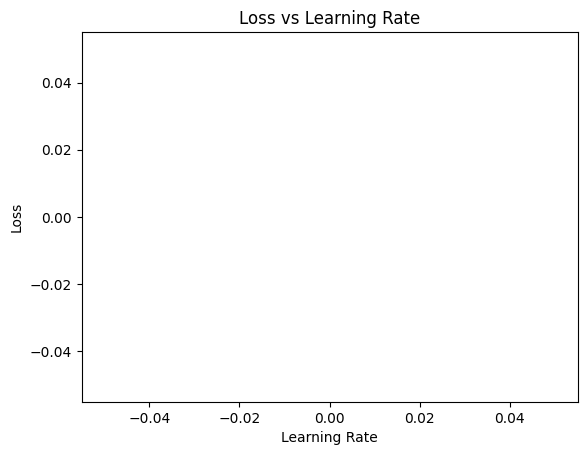

In [75]:
plt.plot(lri, lossi)
plt.xlabel("Learning Rate")     # X-axis label
plt.ylabel("Loss")              # Y-axis label
plt.title("Loss vs Learning Rate")  # Optional: Add a title
plt.show()

# a good learning rate - when learning rate is good the plot is close to 0 on loss axis
# now you can select the learning rate (lr) and hardcode it in the code above

In production it is better to split dataset to 3 splits:
1. training: 80% - use for optimizing parametrs of the model
2. dev/validation: 10% - development of hyperparams (size of the hidden layer, size of the embedding) of your model
3. test: 10% - evaluate performance of the model at the end, do it only few times, because you don't want to train on test split (it can lead to overfitting)!

In [82]:
# build dataset

def build_dataset(words):
  block_size = 3 # context length: how many characters do we take to predict the next one
  X, Y = [], []
  for w in words:

    # print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [83]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [110]:
g = torch.Generator().manual_seed(2147483647) # same generator gives us reproducibility
# lets increase embedding size
C = torch.randn((27, 10), generator=g)
# the easiest way to improve performance of neural network - is to increase neurons in the hidden layer
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [111]:
sum(p.nelement() for p in parameters)

11897

In [112]:
lri = []
lossi = []
stepi = []

In [121]:
for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2

  # count loss
  loss = F.cross_entropy(logits, Ytr[ix])
  # print("Loss", loss.item())

  # backward pass
  for p in parameters:
    p.grad = None # set grad to 0
  loss.backward()

  # update
  # in the beginning lr will be low, but at the end it will be close to 1
  # lr = lrs[i]
  # lr = 10**-1 # start with 0.1
  # lr = 0.01 # use for second iteration
  lr = 0.1 if i < 100_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print("Loss", loss.item())

Loss 2.244501829147339


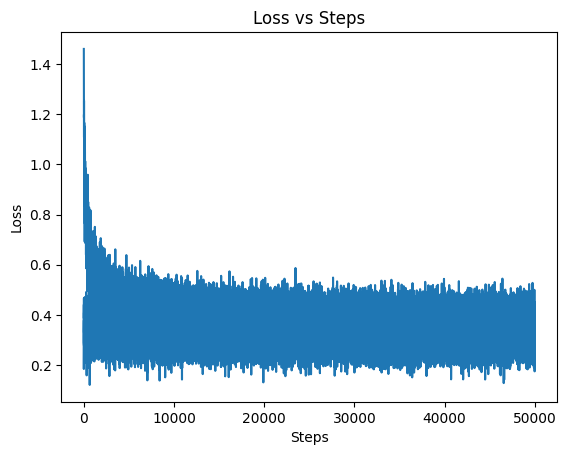

In [122]:
plt.plot(stepi, lossi)
plt.xlabel("Steps")     # X-axis label
plt.ylabel("Loss")              # Y-axis label
plt.title("Loss vs Steps")
plt.show()

In [124]:
  # evaluate loss for against dev data
  emb = C[Xdev] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ydev)
  print("Loss", loss.item())

Loss 2.1968512535095215


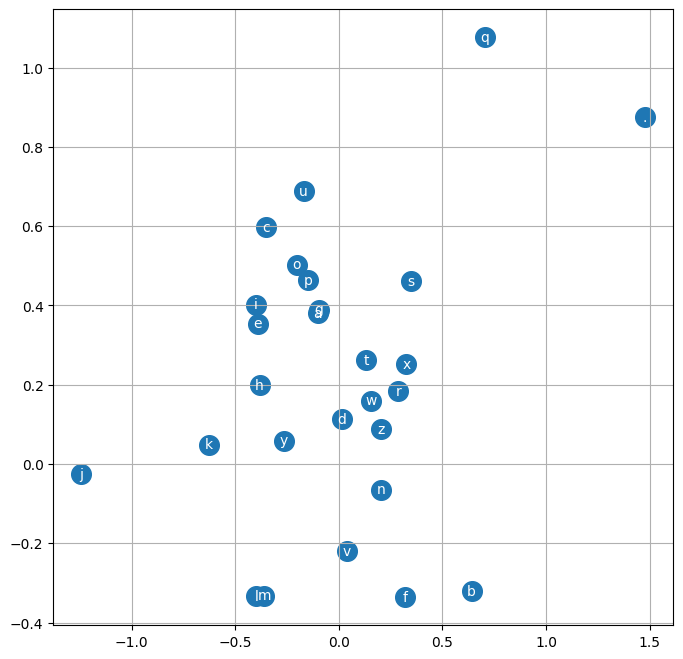

In [125]:
# now the bottleneck can be embedding size, currently it is 2
# let's visualize embedding
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [129]:
# sample from the model
g = torch.Generator().manual_seed(2147483647) # same generator gives us reproducibility

for _ in range(20):

  out = []
  context = [0] * block_size # init with all
  while True:
    # forward pass
    emb = C[torch.tensor([context])] # (1, block_size, d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

junide.
jakasie.
pallay.
adin.
kai.
riton.
aus.
ter.
kalania.
zamilee.
ashibyaine.
amells.
jaiely.
artez.
aveumariffetump.
phya.
leah.
jaylyn.
raaysen.
cara.


In [45]:
# 42:30
# https://youtu.be/TCH_1BHY58I?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ
# https://youtu.be/TCH_1BHY58I?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&t=2554

# https://math.mit.edu/~djk/calculus_beginners/chapter04/section01.html

# also watch pytorch training from freecodecamp 25h